In [2]:
from human_eval.data import write_jsonl, read_problems
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
from codeT import CodeT
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

/home/rrsood/miniconda3/envs/codegen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
problems = read_problems()

In [4]:
# checkpoint = 'facebook/incoder-6B'
# model = AutoModelForCausalLM.from_pretrained(checkpoint, revision="float16", torch_dtype=torch.float16, low_cpu_mem_usage=True).half().cuda()
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [5]:
def extract_function(string):
    defs = [m.start() for m in re.finditer('def ', string)]
    if len(defs) > 1:
        return string[:defs[1]].strip()
    return string.strip()

def extract_testcase(text):
    # Regular expression pattern to match 'assert x == y' or 'assert(x == y)'
    
    pattern1 = r'assert\s+\(?[^\n]*\s*==\s*[^\n]*\)?'
    pattern2 = r'assert\s*\(.*?=\s*.*?\)'
    
    # Find all matches in the text using the pattern
    matches1 = re.findall(pattern1, text)
    matches2 = re.findall(pattern2, text)

    if len(matches1) > 0:
        return matches1[0]
    elif len(matches2) > 0:
        return matches2[0]
    else:
        return ""

In [6]:
def generate_programs(input, max_to_generate=128, temperature=0.2, num_sequences=1):
    BOS = "<|endoftext|>"
    EOM = "<|endofmask|>"
    
    input_ids = tokenizer(input, return_tensors="pt").input_ids
    input_ids = input_ids.to(model.device)
    max_length = max_to_generate + input_ids.flatten().size(0)
    if max_length > 2048:
        print("warning: max_length {} is greater than the context window {}".format(max_length, 2048))
    
    output = model.generate(input_ids=input_ids, do_sample=True, top_p=0.95, 
                            temperature=temperature, max_length=max_length, 
                            num_return_sequences=num_sequences)
    
    generated_programs = []
    for i in range(num_sequences):
        output_seq = output[i]
        detok_hypo_str = tokenizer.decode(output_seq.flatten(), clean_up_tokenization_spaces=False)
        if detok_hypo_str.startswith(BOS):
            detok_hypo_str = detok_hypo_str[len(BOS):]
        
        generated_programs.append(extract_function(detok_hypo_str))
    
    return generated_programs


In [7]:
def generate_testcases(input, max_to_generate=128, temperature=0.2, num_sequences=1):
    BOS = "<|endoftext|>"
    EOM = "<|endofmask|>"
    
    test_input = input + "\n    " + "pass\n\n" + "assert("
    input_ids = tokenizer(test_input, return_tensors="pt").input_ids
    
    
    input_ids = input_ids.to(model.device)
    max_length = max_to_generate + input_ids.flatten().size(0)
    if max_length > 2048:
        print("warning: max_length {} is greater than the context window {}".format(max_length, 2048))
   
    output = model.generate(input_ids=input_ids, do_sample=True, top_p=0.95, 
                            temperature=temperature, max_length=max_length, 
                            num_return_sequences=num_sequences)
    
    generated_tests = []
    for i in range(num_sequences):
        output_seq = output[i]
        detok_hypo_str = tokenizer.decode(output_seq.flatten(), clean_up_tokenization_spaces=False)
        if detok_hypo_str.startswith(BOS):
            detok_hypo_str = detok_hypo_str[len(BOS):]
        
        generated_tests.append(extract_testcase(detok_hypo_str))
    
    return generated_tests

In [8]:
def incoder_generate(input, k=1):
    programs = generate_programs(input, max_to_generate=128, temperature=0.2, num_sequences=k)
    return programs

def incoder_generate_codet(input, n, k=1):
    programs = generate_programs(input, max_to_generate=128, temperature=0.8, num_sequences=n)
    tests = generate_testcases(input, max_to_generate=128, temperature=0.8, num_sequences=n)

    try:
        codet = CodeT(programs, tests, n, k)
        print("Ran CodeT")
        return codet.programs
    except:
        print("No CodeT")
        return programs


In [9]:
# i = 129
# task_ids = list(problems.keys())
# task_id = task_ids[i]
# k=50
# programs = generate_programs(problems[task_id]["prompt"], max_to_generate=128, temperature=0.8, num_sequences=k)
# tests = generate_testcases(problems[task_id]["prompt"], max_to_generate=128, temperature=0.8, num_sequences=k)
# gen_programs = {task_id : programs + programs}
# gen_tests = {task_id : tests + tests}
# sample_programs.append(gen_programs)
# sample_tests.append(gen_tests)

In [10]:
# sample_programs = []
# sample_tests = []
# k=100
# task_ids = list(problems.keys())
# for task_id in tqdm(task_ids[140:164]):
#     programs = generate_programs(problems[task_id]["prompt"], max_to_generate=128, temperature=0.8, num_sequences=k)
#     tests = generate_testcases(problems[task_id]["prompt"], max_to_generate=128, temperature=0.8, num_sequences=k)
    
#     gen_programs = {task_id : programs}
#     gen_tests = {task_id : tests}

#     sample_programs.append(gen_programs)
#     sample_tests.append(gen_tests)

# write_jsonl("incoder_gen_programs_140-163.jsonl", sample_programs)
# write_jsonl("incoder_gen_tests_140-163.jsonl", sample_tests)

In [11]:
# import json
# with open('incoder_humaneval_k100_programs.jsonl') as f:
#     json_programs = json.load(f)

# with open('incoder_humaneval_k100_tests.jsonl') as f:
#     json_tests = json.load(f)

In [12]:
# import multiprocessing
# import time

# def execute_code(code_str, timeout, result_queue):
#     try:
#         # Execute the code
#         exec(code_str)
#         result_queue.put(True)  # Code executed successfully
#     except Exception as e:
#         result_queue.put(False)  # Code raised an exception

# def check_termination_with_timeout(code_str, timeout):
#     result_queue = multiprocessing.Queue()
#     process = multiprocessing.Process(target=execute_code, args=(code_str, timeout, result_queue))
#     process.start()

#     process.join(timeout)  # Wait for the process to finish or timeout
#     if process.is_alive():
#         # Process is still alive after the timeout, terminate it
#         process.terminate()
#         process.join()
#         return False

#     result = result_queue.get()  # Get the result from the child process
#     if result:
#         return True
#     else:
#         return False
    
# def valid_program_testcase_pair(x, y):
#     '''
#     x: a sample program hypothetical inlier
#     y: a sample test case hypothetical inlier
#     returns: True if the sample program passed the test case, False if not
#     '''
    
#     executable = x + "\n" + y 
#     return check_termination_with_timeout(executable, timeout = 0.1)
        
# def get_groups(X, Y, x):
#         '''
#         X: (List[String]) set of programs
#         Y: (List[tuple]) set of test cases
#         x: a sample program hypothetical inlier
#         returns: (S, score) where S is the consensus set of the program x 
#                 and score is the score given to that consensus set
#         '''
        
#         S_y = []
#         for y in Y:
#             if valid_program_testcase_pair(x, y):
#                 S_y.append(y)
        
#         S_x = []
#         for program in X:
#             matching_program = True
#             for y in S_y:
#                 if (not valid_program_testcase_pair(program, y)):
#                     matching_program = False
#                     break
#             if matching_program:
#                 S_x.append(program)
        
#         return S_x, S_y

# def dual_execution_agreement(X, Y, n, k):
#     '''
#     X: (List[string]) list of programs
#     Y: (List[tuple]) test cases
#     k: (int) the number of times we repeat the selection process
#     returns: (S, score) where S is the consensus set with the highest 
#             score based on random sampling over k iterations
#     '''
    
#     patience = 2 * n
#     ctr = 0
#     num_iters = 0
#     clusters = []

#     while ctr < n and num_iters < patience:
#         print(ctr)
#         idx = random.randint(0, len(X) - 1)
#         x, y = X[idx], Y[idx]
#         if valid_program_testcase_pair(x, y):
#             S_x, S_y = get_groups(X, Y, x)
#             score = len(S_x) * len(S_y)
#             clusters.append((S_x, score))
#             ctr += 1
#         num_iters += 1
    
#     print("Made it")
#     if len(clusters) < 1:
#         raise Exception("No matching programs and test \
#                         cases were found with given patience.")
    
#     clusters.sort(key = lambda x : x[1], reverse = True)

#     ctr = 0
#     n_clusters = len(clusters)
#     res = []
#     while ctr < k:
#         cluster_idx = ctr % n_clusters
#         S_x = clusters[cluster_idx][0]
#         program_idx = random.randint(0, len(S_x) - 1)
#         res.append(S_x[program_idx])
#         ctr += 1
    
#     return res

In [13]:
# # Code for running codeT on 100 samples each
# task_ids = list(problems.keys())
# k = 10
# n = 50
# samples = []    # Resulting programs from CodeT

# for i, task_id in tqdm(enumerate(task_ids)):
#     sample_programs = json_programs[i][task_id]
#     sample_tests = json_tests[i][task_id]

#     programs = dual_execution_agreement(sample_programs[:20], sample_tests[:20], n, k)
    
#     for program in programs:
#         gen = dict(task_id=task_id, completion=program)
#         samples.append(gen)

In [14]:
# Code for plotting pass@k vs k
# codet_pass_at_k = [0.2009, 0.2169, 0.2249, 0.2295, 0.2324, 0.2345, 0.2362, 0.2378, 0.2393, 0.2409]
# nocodet_pass_at_k = [0.1665, 0.1928, 0.2072, 0.2174, 0.2252, 0.2314, 0.2366, 0.2413, 0.2457, 0.2500]
# k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# plt.plot(k, codet_pass_at_k, label = "CodeT")
# plt.plot(k, nocodet_pass_at_k, label = "Vanilla")
# plt.title("Incoder-6B Pass@k Accuracy vs k on HumanEval")
# plt.xlabel("k")
# plt.ylabel("Pass@k")
# plt.legend()
# plt.show()

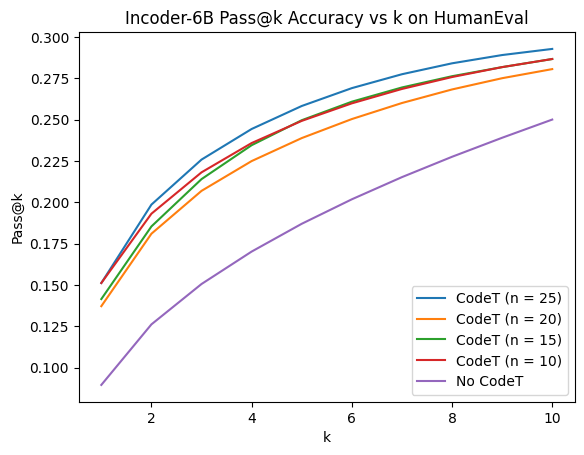

In [15]:
# Code for plotting pass@k vs k (different n's)
no_codet = [0.0896, 0.1262, 0.1506, 0.1702, 0.1870, 0.2018, 0.2152, 0.2275, 0.2390, 0.2500]
codet_n25 = [0.1512, 0.1986, 0.2258, 0.2443, 0.2582, 0.2690, 0.2774, 0.2840, 0.2890, 0.2927]
codet_n20 = [0.1372, 0.1810, 0.2069, 0.2249, 0.2388, 0.2503, 0.2600, 0.2682, 0.2750, 0.2805]
codet_n15 = [0.1415, 0.1854, 0.2140, 0.2345, 0.2496, 0.2608, 0.2694, 0.2762, 0.2817, 0.2866]
codet_n10 = [0.1512, 0.1931, 0.2181, 0.2358, 0.2492, 0.2598, 0.2685, 0.2757, 0.2817, 0.2866]

k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(k, codet_n25, label = "CodeT (n = 25)")
plt.plot(k, codet_n20, label = "CodeT (n = 20)")
plt.plot(k, codet_n15, label = "CodeT (n = 15)")
plt.plot(k, codet_n10, label = "CodeT (n = 10)")
plt.plot(k, no_codet, label = "No CodeT")
plt.title("Incoder-6B Pass@k Accuracy vs k on HumanEval")
plt.xlabel("k")
plt.ylabel("Pass@k")
plt.legend()
plt.show()

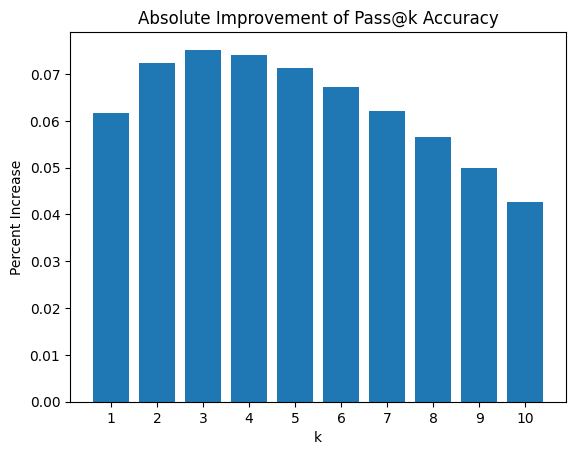

In [19]:
# Bar plot of absolute improvement (best one was n = 25)
improvement = [codet_n25[i] - no_codet[i] for i in range(10)]
k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.bar(k, improvement)
plt.title("Absolute Improvement of Pass@k Accuracy")
plt.ylabel("Percent Increase")
plt.xlabel("k")
plt.xticks(k)
plt.show()